# Assignment 02 Part 2: Neural Net Template

This file contains the template code for the Neural Net with hidden layers.

In [1]:
import numpy as np
import random
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix

# Set random seed for reproduceable results
seed = 100
np.random.seed(seed)

## Artificial Neural Net Class

In [2]:
class ANN:
    def __init__(self, no_inputs=28*28, no_output_nodes=10, no_hidden_layers=2, hidden_layer_size=70,
                 max_iterations=50, learning_rate=0.075, activation_func='sigmoid', batch_size=0.1, sigmoid_output=True):
        """
        Attributes:
            no_inputs (int): the number of input nodes in the network

            no_output_nodes (int): the number of output nodes in the network

            no_hidden_layers (int): the number of hidden layers in the network

            hidden_layer_size (int): the number of neurons in each hidden layer

            max_iterations (int): the number of mini-batches the network will 
            use to for training

            learning rate (float): multiplier to control the rate at which
            learning occurs.

            activation_func (str): activation function used ['sigmoid', 'relu']

            batch_size (float): percentage of training data to be used for each
            mini-batch. The network still uses online learning, this simply 
            allows for more control over the number of iterations and makes
            plotting of progress possible.
            
            sigmoid_output (boolean): determines whether the final layer will
            be used at the output layer when activation_func == 'relu'
        """
        self.no_inputs = no_inputs
        self.no_hidden_layers = no_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.activation_func = activation_func
        self.batch_size = batch_size
        self.sigmoid_output = sigmoid_output
        self.training_acc_list = []  # Used for plotting network performance
        self.validation_acc_list = []  # Used for plotting network performance
        self.min_iteration = 0  # Used for plotting network performance
        self.W = []  # List of weights for each layer
        
        # Ensure the same weights are used for each untrained net
        np.random.seed(seed)
        
        # Create a list with the no. of neurons in each layer
        sizes = [no_inputs]  # First layer in the network, the input layer
        for _ in range(no_hidden_layers):
            sizes.append(hidden_layer_size)  # Add a hidden layer
        sizes.append(no_output_nodes)  # Add the last layer in the network, the output layer
        
        # Initialise lists of random weights and biases for each layer of the network  
        for i in range(len(sizes)-1):
            # Lower st.dev improved performance
            self.W.append(np.random.normal(0, 0.1, size=(sizes[i+1], sizes[i]+1)))
        # Convert list to arrays for manipulation with numpy methods
        self.W = np.array(self.W, dtype='object')

        
    # Activation function
    def activate(self, activation, output_layer=True):
        """
        Activation function used. 
        
        Sigmoid will always be used at the output layer 
        if output_layer == True.
        """
        if (self.activation_func == 'sigmoid') or (output_layer == True):
            output = 1/(1 + np.exp(-activation))
        elif self.activation_func == 'relu':
            output = (activation > 0).astype(int)*activation
        
        return output
    
    
    # Derivative of activation function
    def df_activate(self, output, output_layer=True):
        """
        Derivative of activation function used. 
        
        Derivative of sigmoid will always be used at the 
        output layer if output_layer == True.
        """
        if (self.activation_func == 'sigmoid') or (output_layer == True):
            df = output*(1 - output)
        elif self.activation_func == 'relu':
            df = (output > 0).astype(int)

        return df
    
    
    def predict(self, image, training_mode=True):
        """
        Feed forward single image and return output of each layer (training_mode == False)
        or that of the output layer only (training_mode ==  True)
        """
        outputs = []
        
        for layer in range(self.no_hidden_layers+1):
            if layer == 0:  # Output of first hidden layer
                activation = np.dot(image, self.W[layer].T)
                outputs.append(np.hstack(([1], self.activate(activation))))
            elif layer < self.no_hidden_layers:  # Output of remaining hidden layers
                activation = np.dot(outputs[-1], self.W[layer].T)
                outputs.append(np.hstack(([1], self.activate(activation))))
            else:  # Output of output layer
                activation = np.dot(outputs[-1], self.W[layer].T)
                outputs.append(self.activate(activation, output_layer=self.sigmoid_output))
                
        if not training_mode:
            return outputs[-1]
        else:
            return outputs

        
    def validation_prediction(self, validation_data, validation_labels):
        """      
        Called at the end of every training iteration to track
        performance on a validation set.
        
        Used during debugging and hyperperameter tuning.
        """
        assert len(validation_data) == len(validation_labels)
        val_acc = 0  # How many predictions were correct?
            
        for image, label in zip(validation_data, validation_labels):
            prediction = np.argmax(self.predict(image, training_mode=False))
            val_acc += int(prediction == np.argmax(label))
        val_acc /= len(validation_data)*0.01
        
        return val_acc
        
          
    # Perform one forward & backward pass per image
    def train(self, training_data, labels, validation_data, validation_labels):
        """
        Trains the network and monitors progress at each iteraton.
        
        Weights are updated during the backward pass, updating the weights
        of layer k-1 immediately after calculating the gradient vector
        for layer k.
        """
        assert len(training_data) == len(labels)
        start = time.time()  # start the clock
        print("Training...")
        image_label_pairs = list(zip(training_data, labels))  # So data can be shuffled
        target_met = False  # Set to True when 95% accuracy on training set reached
        np.random.seed(seed)
        
        for iteration in range(self.max_iterations):
            random.shuffle(image_label_pairs)  # Shuffle image-label pairs
            train_accuracy = 0  # How many predictions were correct?
            for i in range(int(len(image_label_pairs)*self.batch_size)):  # For each image in the mini-batch
                image, label = image_label_pairs[i][0], image_label_pairs[i][1]
                ## -- FEEDFORWARD --
                outputs = self.predict(image)
                prediction = outputs[-1]  # Output of final layer
                train_accuracy += int(np.argmax(prediction) == np.argmax(label))  # Was the prediction correct?

                # -- BACKPROPAGATION --
                for layer in range(len(outputs))[::-1]:
                    if layer == self.no_hidden_layers:  # Weights for output layer
                        error = (prediction - label)*self.df_activate(prediction, output_layer=self.sigmoid_output)
                        delta_f = self.learning_rate*np.dot(error[:, np.newaxis], outputs[layer-1][np.newaxis, :])
                    elif layer > 0:  # Weights connecting intermediate hidden layers
                        error = self.df_activate(outputs[layer][1:])*np.dot(error, self.W[layer+1][:, 1:])
                        self.W[layer+1] -= delta_f  # Update weights for layer k+1
                        delta_f = self.learning_rate*np.dot(error[:, np.newaxis], outputs[layer-1][np.newaxis, :])
                    else:  # Weights connecting input to first hidden layer
                        error = self.df_activate(outputs[layer][1:])*np.dot(error, self.W[layer+1][:, 1:])
                        self.W[layer+1] -= delta_f
                        delta_f = np.dot(error[:, np.newaxis], image[np.newaxis, :])
                        self.W[layer] -= delta_f
            
            # Record training accuracy over iteration i
            train_accuracy /= int((len(image_label_pairs)*self.batch_size)*0.01)
            self.training_acc_list.append(train_accuracy)
            
            if (train_accuracy >= 95) and (target_met == False): 
                target_met = True
                self.min_iteration = iteration                
            
            if (len(validation_data) != None) and (len(validation_labels) != None):
                # Perform predictions on validation set and record accuracy
                self.validation_acc_list.append(self.validation_prediction(validation_data, validation_labels))
            
        # How long did training take?
        end = time.time()
        clear_output()
        print(f"It took {int(end-start)} seconds to train the network with the {self.activation_func} activation function. An accuracy of 95% or above was reached at iteration {self.min_iteration}.")
    
    
    def test(self, testing_data, labels):
        """
        Predicts the label for all images in test set and
        displays performance metrics.
        """
        assert len(testing_data) == len(labels)
        predictions, targets = [], []
                
        for image, label in zip(testing_data, labels):
            prediction = np.argmax(self.predict(image, training_mode=False))
            predictions.append(prediction)
            target = np.argmax(label)
            targets.append(target)
        
        conf_m = confusion_matrix(targets, predictions)
        
        # Calculate precision and recall per class
        label_names = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']
        # 'normalise' argument normalises conf mat by row ('true') or column ('pred')
        recall = confusion_matrix(targets, predictions, normalize='true').diagonal()
        precision = confusion_matrix(targets, predictions, normalize='pred').diagonal()
        metrics = pd.DataFrame({'Recall':recall, 'Precision':precision}, index=label_names)
        
        _, ax = plt.subplots(figsize=(8, 8))
        ax.matshow(conf_m, cmap='gray')
        plt.title('Predicted')
        plt.ylabel('Actual')

        for (i, j), z in np.ndenumerate(conf_m):
            ax.text(j, i, str(z), ha='center', va='center',
                   bbox=dict(facecolor='white', boxstyle='round'))
        plt.tight_layout()
        plt.show()
        
        #print(conf_m)
        print('\n', metrics, '\n')
        accuracy = sum(conf_m.diagonal())/len(targets)
        #print(sum(conf_m.diagonal()), len(targets))
        print("Accuracy:  {:.1f}%".format(100*accuracy))
    
        
    def plot_progress(self, plot_validation=True):
        """
        Plots the neural network's accuracy on the training and validation sets.
        
        plot_validation = False should be used when no validation set is created.
        """
        plt.figure(figsize=(8, 6))
        plt.plot(self.training_acc_list, "r-", label="Train")
        if plot_validation:
            plt.plot(self.validation_acc_list, "b-", label="Validation")
        plt.legend(loc="lower right", fontsize=12)
        plt.title('Training vs Validation')
        plt.ylabel('Accuracy')
        plt.xlabel('Iterations')
        plt.ylim(40, 100)
        if self.min_iteration > 0:
            plt.axvline(x=self.min_iteration, linestyle ="--", color ='g')
        plt.tight_layout()
        plt.show()
        
        print('Final training accuracy: {:.1f}%'.format(self.training_acc_list[-1]))
        print('Final validation accuracy: {:.1f}%'.format(self.validation_acc_list[-1]))

### Main method

The following cell(s) should complete parts 2.1 to 2.5.

In [3]:
# Load train/test data
data_path = "./"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")

In [4]:
# Replace target with bias value and scale inputs down to the range [0.01, 1]
train_x_full = [np.append([1], d[1:]*(0.99/255)+0.01) for d in train_data]
test_x = [np.append([1], d[1:]*(0.99/255)+0.01) for d in test_data]
train_x = train_x_full[:55000]
val_x = train_x_full[55000:]

# Identify targets for train, validation, and test
train_y_full = np.asfarray(train_data[:, :1])
test_y = np.asfarray(test_data[:, :1])
train_y = train_y_full[:55000]
val_y = train_y_full[55000:]

# One-hot encoding
lr = np.arange(10)
train_y_ohe = (lr==train_y).astype(np.float)
val_y_ohe = (lr==val_y).astype(np.float)
test_y_ohe = (lr==test_y).astype(np.float)

Each of the below deliver the best results in an acceptable period (2-3 minutes). In both cases a small performance improvment can be achieved with several hundred iterations, increasing the number of neurons in the hidden layer, and/or additional hidden layers - but this demands longer run times.

**Current Best Sigmoid**:

```ANN(no_hidden_layers=1, hidden_layer_size=150, max_iterations=80, activation_func='sigmoid', learning_rate=0.075, batch_size=0.1)```
_________________________________________________________________________________________________________________________________
**Current Best ReLu**:

```ANN(no_hidden_layers=1, hidden_layer_size=150, max_iterations=80, activation_func='relu', learning_rate=0.01, batch_size=0.1)```  

### Sigmoid

In [5]:
sigmoid_net = ANN(no_hidden_layers=1, hidden_layer_size=150, max_iterations=80, activation_func='sigmoid', learning_rate=0.075, batch_size=0.1)

In [6]:
sigmoid_net.train(train_x, train_y_ohe, val_x, val_y_ohe)

It took 137 seconds to train the network with the sigmoid activation function. An accuracy of 95% or above was reached at iteration 8.


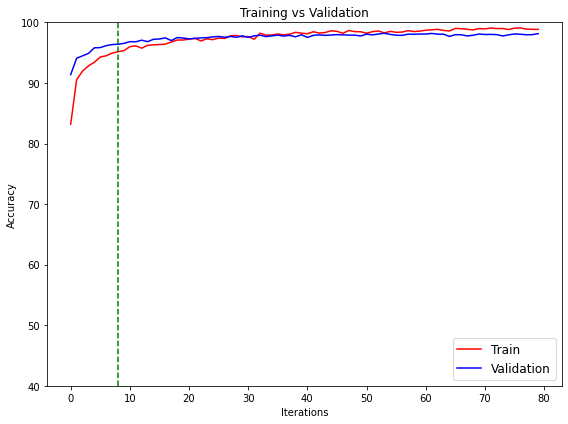

Final training accuracy: 98.9%
Final validation accuracy: 98.1%


In [7]:
sigmoid_net.plot_progress()

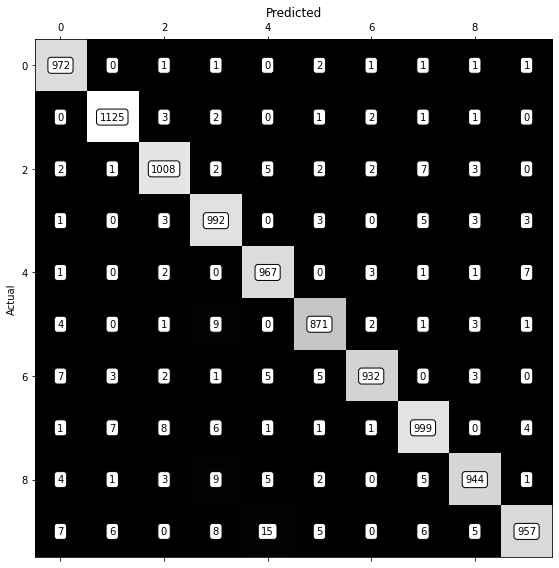


          Recall  Precision
Zero   0.991837   0.972973
One    0.991189   0.984252
Two    0.976744   0.977692
Three  0.982178   0.963107
Four   0.984725   0.968938
Five   0.976457   0.976457
Six    0.972860   0.988335
Seven  0.971790   0.973684
Eight  0.969199   0.979253
Nine   0.948464   0.982546 

Accuracy:  97.7%


In [8]:
sigmoid_net.test(test_x, test_y_ohe)

### Comments on performance

***How much better are the results for digit recognition, compared to the single-layer perceptron?***

To compare the neural network performing multi-class classification with the perceptrons performing binary classification, consider how the perceptrons would perform when working together within a voting classifier, where the predicted class is given by the index of the largest activation (argmax) of all perceptrons. Each perceptron would output a value between 0 and 1 when a sigmoid function is applied to the activation, and the perceptron with the most confidence in it's output would put forward the final vote for the ensemble of perceptrons.

Rather than benefitting from the combined learnings of all perceptrons - as usually expected from an ensemble - the performance will likely suffer as a result of one or more particularly weak classifiers outputting wrong predictions with higher confidence than other classifiers offering the correct prediction with lower confidence. With some perceptrons attaining <= 80% precision and/or recall, we can conclude the neural network would much better at the multi-digit recognition problem given it consistently achieves precision and recall scores of > 90% across all digits.
_________________
***How did you modify the initial weights, learning rate, and iterations to achieve this?***

In an attempt to avoid dead neurons when using the ReLu activation function, weights were initialised from a normal distribution with a mean of 0 and **standard deviation of 0.1** rather than the frequently recommended standard deviation of 1. This resulted in a substantial improvement in the performance of the network with both activation functions. The often default learning rate of 0.01 worked well but I found 0.0075 to work better than this or 0.005 (and values outwith this range). As plotted above, an accuracy of 95% or higher can be achieved in 10-20 iterations or less with a batch size of 0.1 (1-2 iterations over all 55,000 images in the training set). Also worth noting is that the network appears to perform better and faster with a single layer with many neurons rather than several layers of fewer neurons. Training is run for 80 iterations to compare it's training time with that of the ReLu activation function below since it typically benefits from more iterations.
_________________
***How much faster/slower is the training time, compared to the single-layer perceptron?***

It is much slower than training a single perceptron (approx 7-10 seconds for 20 iterations) but faster than training 10 perceptrons to a point where their performance comes anywhere near than of the neural network (~120 seconds for 20 iterations per perceptron using online learning and a sigmoid activation, compared to the ~110 seconds for the neural network). These times could be cut down by removing code which tracks performance.
_________________
***How much quicker/slower does the learning converge, compared to the single-layer perceptron?***

Considering accuracy on the training set as a basis for comparison, the above plot shows the network's rate of learning falls rapidly after ~10 iterations (== 1 iteration over 55,000 images) and shows little improvement after 40 iterations; while a single perceptron trained with online learning using a sigmoid activation function also appears to converage after a single iteration over all 60,000 images in the training set - although a batch size was not used here so it may converage even sooner than this.

### ReLu (with sigmoid)

In [9]:
relu_net = ANN(no_hidden_layers=1, hidden_layer_size=150, max_iterations=80, activation_func='relu', learning_rate=0.0075, batch_size=0.1, sigmoid_output=True)

In [10]:
relu_net.train(train_x, train_y_ohe, val_x, val_y_ohe)

It took 126 seconds to train the network with the relu activation function. An accuracy of 95% or above was reached at iteration 14.


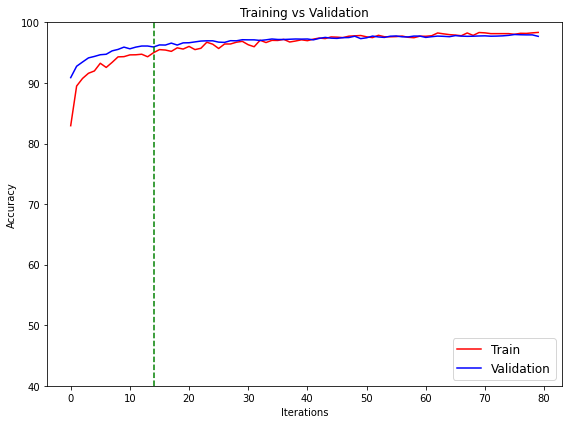

Final training accuracy: 98.3%
Final validation accuracy: 97.7%


In [11]:
relu_net.plot_progress()

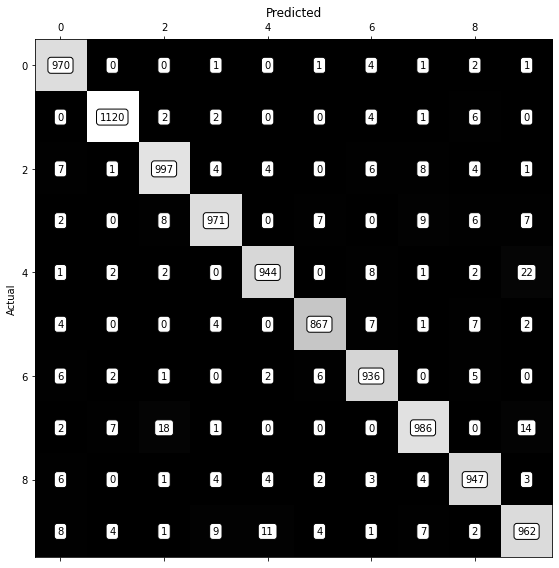


          Recall  Precision
Zero   0.989796   0.964215
One    0.986784   0.985915
Two    0.966085   0.967961
Three  0.961386   0.974900
Four   0.961303   0.978238
Five   0.971973   0.977452
Six    0.977035   0.965944
Seven  0.959144   0.968566
Eight  0.972279   0.965341
Nine   0.953419   0.950593 

Accuracy:  97.0%


In [12]:
relu_net.test(test_x, test_y_ohe)

### Comments on performance

***How much better are the results for digit recognition, compared to the sigmoid activation function?***

When using the ReLu activation function for all layers but the output layer the largest improvement found was a 1.5% increase in accuracy, although the margin is often smaller and sometimes it underperforms the sigmoid activation function. Additionally, as seen in the above plots, both the training and validation accuracy for the `relu_net` reach ~95% accuracy within 15 iterations then remain fairly steady for the remainder; almost identical to the `sigmoid_net`. When all layers use the ReLu activation function, performance tends to be weaker and much less consistent, with accuracy scores ranging from 50% to 95% rather than the 96-98% range observed when using a sigmoid activation function at the final layer.

This single sigmoid layer was initially implemented to combat the explosion and/or death of neurons when using ReLu, on the basis that the MSE of the outputs would be much smaller and thus propagate much smaller errors back through the network. Rather than act as a temporary solution, it has allowed for an architecture that cannot be outperformed by a network of ReLu layers alone - for my implementation at least. Hence, the remainder of this commentary will refer to this hybrid architecture, with code to create the best observed ReLu-only network below.
___
***How much quicker/slower does the learning converge, compared to the sigmoid activation function?***

Somewhat surprisingly, the `relu_net` consistently takes longer to train for N iterations; and the number of iterations required to reach ~95% accuracy is about the same for both activation functions - although it will sometimes require more iterations than the sigmoid net. Although the difference is small, the expected outcome was for the `relu_net` to be as least as fast as the `sigmoid_net` given the exponential calculation used by the sigmoid activation function and the barrier presented by saturation of sigmoid neurons in response to large or small activation values.
___
***How did you modify the initial weights, learning rate, and iterations to achieve this?***

The learning rate was dropped (7.5x smaller), more iterations were required to attain superior performance over the `sigmoid_net`, and as previously mentioned, the standard deviation of the normal distribution from which the initial weights were drawn was dropped from 1 to 0.1 on account all nodes eventually dying, outputting only 0.

### ReLu Only

In [13]:
relu_only_net = ANN(no_hidden_layers=1, hidden_layer_size=50, max_iterations=80, activation_func='relu', learning_rate=0.001, batch_size=0.1, sigmoid_output=False)

In [ ]:
relu_only_net.train(train_x, train_y_ohe, val_x, val_y_ohe)

Training...


In [ ]:
relu_only_net.plot_progress()

In [ ]:
relu_only_net.test(test_x, test_y_ohe)